In [1]:
import pickle
import torch.nn as nn
import torch.utils.data
import matplotlib.pyplot as plt

In [2]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 10

# Size of z latent vector (i.e. size of generator input)
latent_dim = 100

# Size of feature maps in generator
m_size = 100

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0001


In [3]:
#Loading dataset
with open('ds_train.pickle', 'rb') as f:
    dataset = pickle.load(f)

In [4]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

real_batch = next(iter(dataloader))

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(m_size**2, 1250),
            nn.ReLU(),
            nn.Linear(1250, 850),
            nn.ReLU(),
            nn.Linear(850,425),
            nn.ReLU(),
            nn.Linear(425,100),
            nn.ReLU(),
            nn.Linear(100,1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [6]:
discriminator = Discriminator()

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, m_size**2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

In [8]:
# Initialize BCELoss function
loss_function = nn.BCELoss()

In [9]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [10]:
G_losses = []
D_losses = []
for epoch in range(num_epochs):
    for n, (real_samples) in enumerate(dataloader,0):
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.rand((batch_size, latent_dim))
        generated_samples = generator(latent_space_samples)
        generated_samples = generated_samples.view(batch_size, m_size, m_size)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        discriminator.zero_grad()
        all_samples = all_samples.view(batch_size*2, -1)
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()
        latent_space_samples = torch.rand((batch_size, latent_dim))

        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        G_losses.append(loss_generator.item())
        D_losses.append(loss_discriminator.item())

        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.6644932627677917
Epoch: 0 Loss G.: 0.7426209449768066
Epoch: 1 Loss D.: 1.0792967081069946
Epoch: 1 Loss G.: 13.57110595703125
Epoch: 2 Loss D.: 0.1977444887161255
Epoch: 2 Loss G.: 6.656052589416504
Epoch: 3 Loss D.: 0.046119771897792816
Epoch: 3 Loss G.: 6.079687595367432
Epoch: 4 Loss D.: 0.1283041536808014
Epoch: 4 Loss G.: 5.860581874847412
Epoch: 5 Loss D.: 0.014296305365860462
Epoch: 5 Loss G.: 3.912930965423584
Epoch: 6 Loss D.: 0.059002239257097244
Epoch: 6 Loss G.: 4.39129638671875
Epoch: 7 Loss D.: 0.05907974764704704
Epoch: 7 Loss G.: 3.1145381927490234
Epoch: 8 Loss D.: 0.030929183587431908
Epoch: 8 Loss G.: 2.8728907108306885
Epoch: 9 Loss D.: 0.06633733212947845
Epoch: 9 Loss G.: 4.100534915924072
Epoch: 10 Loss D.: 0.019958671182394028
Epoch: 10 Loss G.: 3.4582836627960205
Epoch: 11 Loss D.: 0.0080877635627985
Epoch: 11 Loss G.: 4.41606330871582
Epoch: 12 Loss D.: 0.6180540919303894
Epoch: 12 Loss G.: 8.248663902282715
Epoch: 13 Loss D.: 0.0128681715

In [11]:
latent_space_samples = torch.rand(batch_size, latent_dim)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.view(batch_size, m_size, m_size)
print(generated_samples[0])

tensor([[-1.0077e-02,  7.8712e-03,  1.8841e-02,  ...,  1.2171e-03,
          4.4638e-03,  4.7984e-03],
        [ 1.0042e-02, -1.7670e-03,  1.7939e-01,  ..., -2.1233e-03,
         -2.7120e-03,  2.3214e-03],
        [ 1.9208e-01,  3.7266e-02, -7.1155e-03,  ...,  6.6182e-04,
          5.5460e-03, -4.2158e-04],
        ...,
        [ 6.1760e-03,  7.1478e-03,  5.7643e-03,  ...,  4.9056e-03,
          1.2710e-02, -2.3472e-04],
        [ 3.2119e-05,  6.1154e-03, -1.2217e-02,  ...,  8.4083e-03,
          7.2522e-03,  5.5176e-03],
        [-4.2891e-03,  8.7375e-03, -7.0943e-03,  ..., -9.2078e-03,
          4.4697e-03,  4.9901e-03]], grad_fn=<SelectBackward0>)


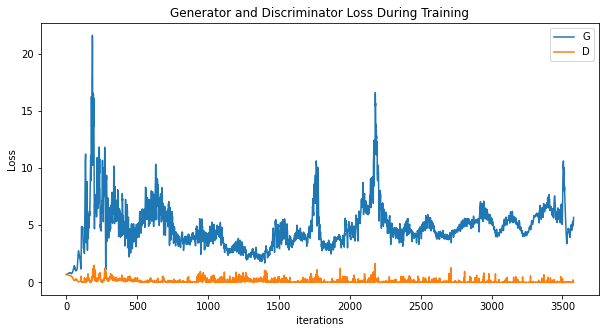

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()